In [21]:
from ncaa_pbp import Game
from utility import get_Teams

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
gamesTable = pd.read_csv("games_2023-24.csv")
gamesTable

,Date,Opponent,Result,Attendance,GameID
0,11/06/2023,"('Bradley', '/teams/560625')",W 73-66,"('1,203', None)",3970221
1,11/11/2023,"('@ UTEP', '/teams/561157')",L 60-62,"('1,093', None)",3970806
2,11/14/2023,"('Utah St.', '/teams/561181')",L 60-62,"('462', None)",3971414
3,11/18/2023,"('Kansas @Kansas City, MO', '/teams/560831')",L 61-70,"('867', None)",3972102
4,11/22/2023,"('Chicago St. @Cleveland, OH (23-24 WBB Viking...",W 77-46,"('418', None)",3972603
...,...,...,...,...,...
11454,03/02/2024,"('Saint Francis (PA)', '/teams/561057')",W 56-24,"('656', None)",3984511
11455,03/11/2024,"('#7 Stonehill 23-24 WBB NEC Tournament', '/te...",W 79-59,"('181', None)",5249793
11456,03/14/2024,"('#3 FDU 23-24 WBB NEC Tournament', '/teams/56...",W 52-38,"('214', None)",5249791
11457,03/17/2024,"('#1 Sacred Heart 23-24 WBB NEC Tournament', '...",L 48-69,"('1,467', None)",5249789


In [3]:
game_date_map = dict(zip(gamesTable.GameID.tolist(), gamesTable.Date.tolist()))


In [4]:
games = []
for game in tqdm(gamesTable.loc[gamesTable.GameID.duplicated()].GameID):
    games.append(Game(game, source='file'))

  0%|          | 8/5560 [00:16<3:28:42,  2.26s/it]

100%|██████████| 5560/5560 [1:14:02<00:00,  1.25it/s]  


In [5]:
df = pd.DataFrame()

for game in tqdm(games):
    for teamid, box in game.boxScore.items():
        stats = box.iloc[-1].copy()
        stats['Team ID'] = teamid
        stats['Opponent ID'] = [team for team in game.teams if team != teamid][0]
        stats['Game ID'] = game.gameId
        df = pd.concat([df, stats.to_frame().T])

100%|██████████| 5560/5560 [01:11<00:00, 77.23it/s] 


In [8]:
df = df.drop(columns=['#', 'P', 'GS'])

In [6]:
df.to_csv('box_scores_2023_24.csv')

In [9]:
teams_info = get_Teams(2024)
id_conf_map = {url.split('/')[-1]:conf for url, conf in teams_info.values()}
id_name_map = {info[0].split('/')[-1]:name for name, info in teams_info.items()}


In [10]:
df['Opponent Name'] = df['Opponent ID'].map(id_name_map)
df['Conference'] = df['Team ID'].map(id_conf_map)
df['Opponent Conference'] = df['Opponent ID'].map(id_conf_map)
df['Date'] = pd.to_datetime(df['Game ID'].map(game_date_map))

In [11]:
regularSeason = df.query("`Date`<=20240317").sort_values('Date')
confDf = regularSeason.query('Conference==`Opponent Conference`')
nonconfDf = regularSeason.query('Conference!=`Opponent Conference`')

In [12]:
nonconfDf.columns

Index(['Name', 'MP', 'FGM', 'FGA', '3FG', '3FGA', 'FT', 'FTA', 'PTS', 'ORebs',
       'DRebs', 'Tot Reb', 'AST', 'TO', 'STL', 'BLK', 'PF', 'DQ', 'Tech Fouls',
       'Team ID', 'Opponent ID', 'Game ID', 'Opponent Name', 'Conference',
       'Opponent Conference', 'Date'],
      dtype='object')

In [33]:
nonconfStats = nonconfDf.drop(columns=['MP', 'Team ID', 'Opponent ID', 'Game ID', 'Conference',
       'Opponent Conference', 'Opponent Name', 'Date']).groupby('Name').sum()
nonconfStats.index.name = None

nonconfStats.drop(index='Chicago St.', inplace=True) # Team is independent and thus had no conference games

nonconfStats = nonconfStats.astype(float)

nonconfStats['Poss'] = nonconfStats['FGA'] + nonconfStats['TO'] + 0.42 * nonconfStats['FTA'] - nonconfStats['ORebs']
nonconfStats['3pt Rate'] = nonconfStats['3FGA'] / nonconfStats['FGA']
nonconfStats['Ast%'] = nonconfStats['AST'] / nonconfStats['FGM']
nonconfStats['OReb%'] = nonconfStats['ORebs'] / (nonconfStats['FGA'] - nonconfStats['FGM']) # Adjust for free throws
nonconfStats['FG%'] = nonconfStats['FGM'] / nonconfStats['FGA']
nonconfStats['3FG%'] = nonconfStats['3FG'] / nonconfStats['3FGA']
nonconfStats['FT%'] = nonconfStats['FT'] / nonconfStats['FTA']
nonconfStats['TO%'] = nonconfStats['TO'] / nonconfStats['Poss']
nonconfStats['Blk%'] = nonconfStats['BLK'] / nonconfStats['Poss']
nonconfStats['Stl%'] = nonconfStats['STL'] / nonconfStats['Poss']
nonconfStats['PPP'] = nonconfStats['PTS'] / nonconfStats['Poss']
nonconfStats['Foul Rate'] = nonconfStats['PF'] / nonconfStats['Poss']
nonconfStats['FT Rate'] = nonconfStats['FTA'] / nonconfStats['FGA']


In [34]:
confStats = confDf.drop(columns=['MP', 'Team ID', 'Opponent ID', 'Game ID', 'Conference',
       'Opponent Conference', 'Opponent Name', 'Date']).groupby('Name').sum()
confStats.index.name = None

confStats.loc['IU Indy'] = confStats.loc['IU Indy'] + confStats.loc['IUPUI'] # IU Indy was under two different names
confStats.drop(index='IUPUI', inplace=True)

confStats = confStats.astype(float)

confStats['Poss'] = confStats['FGA'] + confStats['TO'] + 0.42 * confStats['FTA'] - confStats['ORebs']
confStats['3pt Rate'] = confStats['3FGA'] / confStats['FGA']
confStats['Ast%'] = confStats['AST'] / confStats['FGM']
confStats['OReb%'] = confStats['ORebs'] / (confStats['FGA'] - confStats['FGM']) # Adjust for free throws
confStats['FG%'] = confStats['FGM'] / confStats['FGA']
confStats['3FG%'] = confStats['3FG'] / confStats['3FGA']
confStats['FT%'] = confStats['FT'] / confStats['FTA']
confStats['TO%'] = confStats['TO'] / confStats['Poss']
confStats['Blk%'] = confStats['BLK'] / confStats['Poss']
confStats['Stl%'] = confStats['STL'] / confStats['Poss']
confStats['PPP'] = confStats['PTS'] / confStats['Poss']
confStats['Foul Rate'] = confStats['PF'] / confStats['Poss']
confStats['FT Rate'] = confStats['FTA'] / confStats['FGA']

In [15]:
plt.style.use('Solarize_Light2')

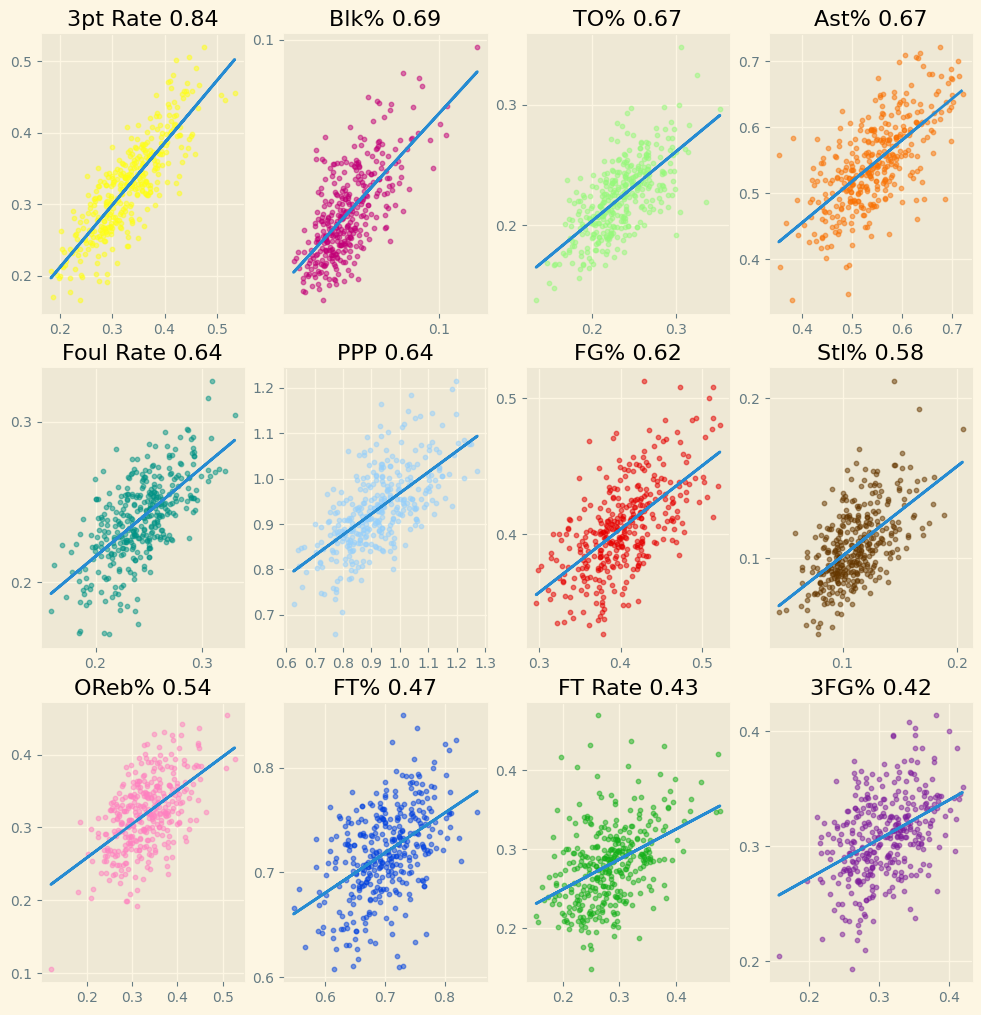

In [36]:
options = ['3pt Rate', 'Ast%', 'OReb%', 'FG%', '3FG%', 'FT%', 'TO%', 'Blk%', 'Stl%', 'PPP', 'Foul Rate', 'FT Rate']
colors = list(mcolors.XKCD_COLORS.values())[-len(options):]
corrcoefs = {stat:np.corrcoef(nonconfStats[stat],confStats[stat])[0,1] for stat in options}
stat = options[-1]

ncols = 4
nrows = int(np.ceil(len(options) / ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*4.1))
for i, stat in enumerate(sorted(options, key=corrcoefs.get, reverse=True)):
    row_ix = i // ncols
    col_ix = i % ncols

    x = nonconfStats[stat]
    y = confStats[stat]

    #ax[row_ix, col_ix].grid(True)
    ticks = np.arange(0,2,.1)
    ax[row_ix, col_ix].set_xticks(ticks)
    ax[row_ix, col_ix].set_yticks(ticks)
    limit_min = min(x.min(), y.min()) - 0.1
    limit = max(x.max(), y.max()) + 0.1
    #ax[row_ix, col_ix].set_xlim([limit_min,limit])
    #ax[row_ix, col_ix].set_ylim([limit_min,limit])


    ax[row_ix, col_ix].scatter(x, y, s=10, alpha=.5, c=colors[i])
    # fitting a linear regression line
    m, b = np.polyfit(x.to_numpy(), y.to_numpy(), 1)

    # adding the regression line to the scatter plot
    ax[row_ix, col_ix].plot(x, m*x + b, )#c='gray')

    ax[row_ix, col_ix].set_title(f'{stat} {round(corrcoefs[stat], 2)}')
    

# Player Stats

In [23]:
players = pd.DataFrame()

for game in tqdm(games):
    for teamid, box in game.boxScore.items():
        stats = box.iloc[:-2].copy()
        stats['Team ID'] = teamid
        stats['Opponent ID'] = [team for team in game.teams if team != teamid][0]
        stats['Game ID'] = game.gameId
        players = pd.concat([players, stats])

100%|██████████| 5560/5560 [02:28<00:00, 37.33it/s]


In [24]:
players.to_csv('box_scores_players_2023_24.csv')

In [25]:
players = players.drop(columns=['#'])

In [26]:
players['Opponent Name'] = players['Opponent ID'].map(id_name_map)
players['Conference'] = players['Team ID'].map(id_conf_map)
players['Opponent Conference'] = players['Opponent ID'].map(id_conf_map)
players['Date'] = pd.to_datetime(players['Game ID'].map(game_date_map))

In [27]:
def minutesStringToFloat(mmss):
    try:
        times = mmss.split(':')
        return float(times[0]) + float(times[1]) / 60
    except:
        print(mmss)
        return 0

#players.query('~MP.str.contains(":")')
players['MP'] = players.MP.apply(minutesStringToFloat)

0
0
0


In [28]:
playRegularSeason = players.query("`Date`<=20240317").sort_values('Date')
playConfDf = playRegularSeason.query('Conference==`Opponent Conference`')
playNonconfDf = playRegularSeason.query('Conference!=`Opponent Conference`')

In [29]:
minutesThreshold = 150

In [125]:
nonconfStats = playNonconfDf.drop(columns=['P', 'Team ID', 'Opponent ID', 'Game ID', 'Conference',
       'Opponent Conference', 'Opponent Name', 'Date']).groupby('Name').sum()
nonconfStats.index.name = None

nonconfStats = nonconfStats.astype(float)
nonconfStats = nonconfStats.query(f'MP>{minutesThreshold}')
nonconfStats['GP'] = nonconfStats.index.map(playNonconfDf.groupby('Name').PTS.count().to_dict()).to_list()

nonconfStats['3FGA per 30'] = nonconfStats['3FGA'] / nonconfStats['MP'] * 30
nonconfStats['Ast per 30'] = nonconfStats['AST'] / nonconfStats['MP'] * 30
nonconfStats['OReb per 30'] = nonconfStats['ORebs'] / nonconfStats['MP'] * 30
nonconfStats['DReb per 30'] = nonconfStats['DRebs'] / nonconfStats['MP'] * 30
nonconfStats['FG%'] = nonconfStats['FGM'] / nonconfStats['FGA']
nonconfStats['3FG%'] = nonconfStats['3FG'] / nonconfStats['3FGA']
nonconfStats['FT%'] = nonconfStats['FT'] / nonconfStats['FTA']
nonconfStats['TO per 30'] = nonconfStats['TO'] / nonconfStats['MP'] * 30
nonconfStats['Blk per 30'] = nonconfStats['BLK'] / nonconfStats['MP'] * 30
nonconfStats['Stl per 30'] = nonconfStats['STL'] / nonconfStats['MP'] * 30
nonconfStats['Pts per 30'] = nonconfStats['PTS'] / nonconfStats['MP'] * 30
nonconfStats['FGA per 30'] = nonconfStats['FGA'] / nonconfStats['MP'] * 30
nonconfStats['PF per 30'] = nonconfStats['PF'] / nonconfStats['MP'] * 30
nonconfStats['FTA per 30'] = nonconfStats['FTA'] / nonconfStats['MP'] * 30
nonconfStats['MPG'] = nonconfStats['MP'] / nonconfStats['GP']


In [126]:
games[0]

In [62]:
confStats = playConfDf.drop(columns=['P', 'Team ID', 'Opponent ID', 'Game ID', 'Conference',
       'Opponent Conference', 'Opponent Name', 'Date']).groupby('Name').sum()
confStats.index.name = None

confStats = confStats.astype(float)
confStats = confStats.query(f'MP>{minutesThreshold}')
confStats['GP'] = confStats.index.map(playConfDf.groupby('Name').PTS.count().to_dict()).to_list()

confStats['3FGA per 30'] = confStats['3FGA'] / confStats['MP'] * 30
confStats['Ast per 30'] = confStats['AST'] / confStats['MP'] * 30
confStats['OReb per 30'] = confStats['ORebs'] / confStats['MP'] * 30
confStats['DReb per 30'] = confStats['DRebs'] / confStats['MP'] * 30
confStats['FG%'] = confStats['FGM'] / confStats['FGA']
confStats['3FG%'] = confStats['3FG'] / confStats['3FGA']
confStats['FT%'] = confStats['FT'] / confStats['FTA']
confStats['TO per 30'] = confStats['TO'] / confStats['MP'] * 30
confStats['Blk per 30'] = confStats['BLK'] / confStats['MP'] * 30
confStats['Stl per 30'] = confStats['STL'] / confStats['MP'] * 30
confStats['Pts per 30'] = confStats['PTS'] / confStats['MP'] * 30
confStats['FGA per 30'] = confStats['FGA'] / confStats['MP'] * 30
confStats['PF per 30'] = confStats['PF'] / confStats['MP'] * 30
confStats['FTA per 30'] = confStats['FTA'] / confStats['MP'] * 30
confStats['MPG'] = confStats['MP'] / confStats['GP']


In [64]:
# Get rid of players who didn't play in both nonconf and conf
players_ix = confStats.loc[confStats.index.isin(nonconfStats.index)].index

nonconfStats = nonconfStats.loc[players_ix]
confStats = confStats.loc[players_ix]

In [65]:
nonconfStats.fillna(0, inplace=True)
confStats.fillna(0, inplace=True)

In [66]:
len(confStats.index)

2305

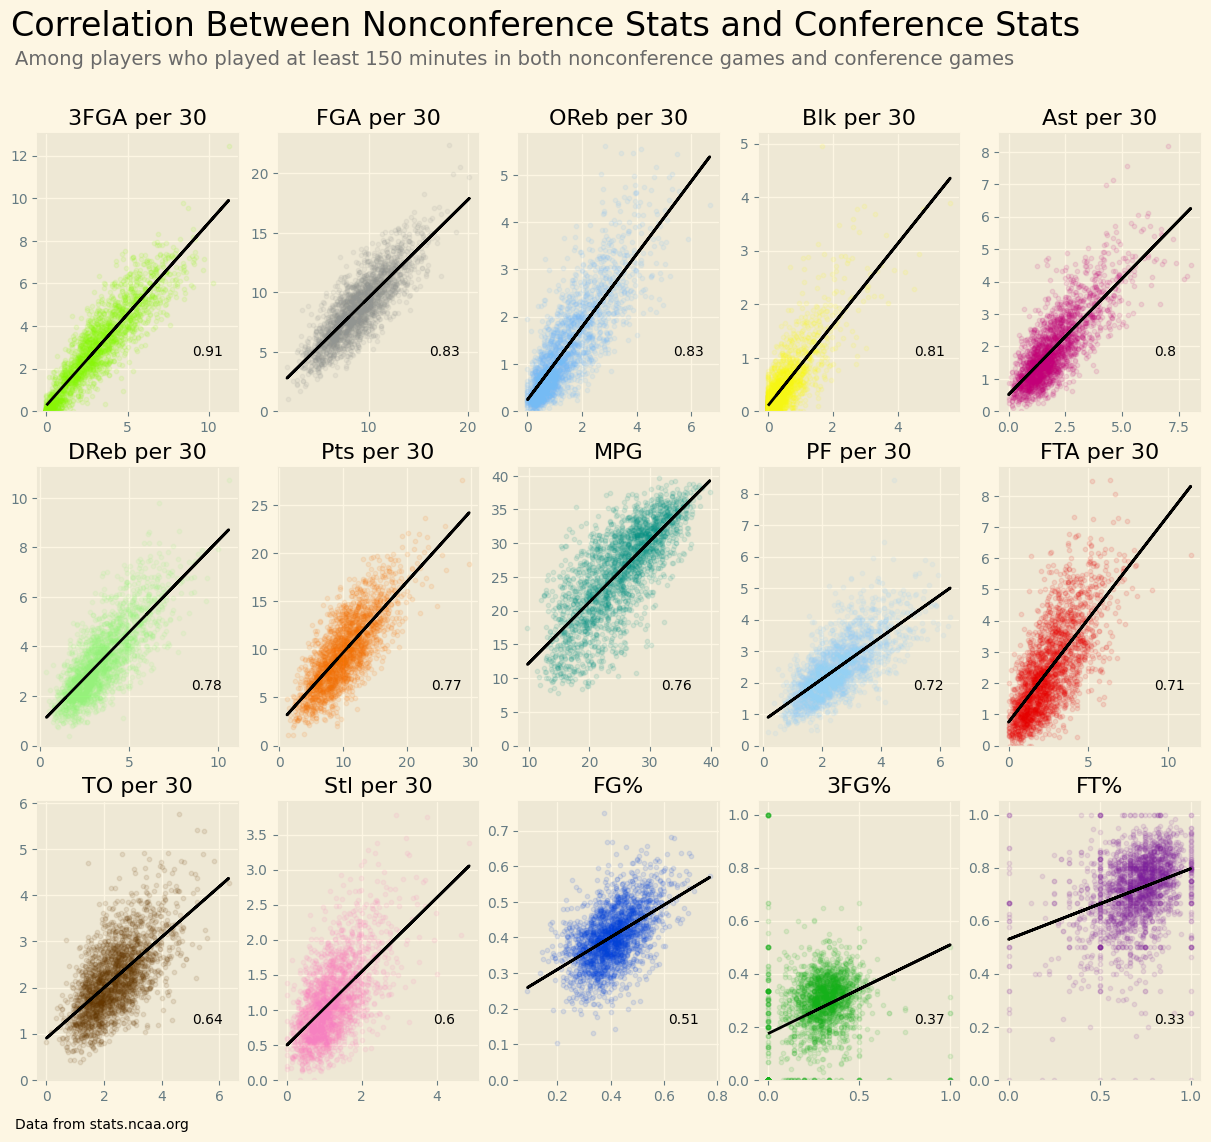

In [124]:
options = ['3FGA per 30', 'Ast per 30', 'OReb per 30', 'DReb per 30', 'FG%',
       'TO per 30', 'Blk per 30', 'Stl per 30', 'Pts per 30', 'FGA per 30', 'PF per 30', 'FTA per 30', '3FG%', 'FT%', 'MPG'] # , '3FG%', 'FT%', 'MPG'
colors = list(mcolors.XKCD_COLORS.values())[-len(options):]
corrcoefs = {stat:np.corrcoef(nonconfStats[stat],confStats[stat])[0,1] for stat in options}
stat = options[-1]

ncols = 5
nrows = int(np.ceil(len(options) / ncols))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*4.1))
for i, stat in enumerate(sorted(options, key=corrcoefs.get, reverse=True)):
    row_ix = i // ncols
    col_ix = i % ncols

    x = nonconfStats[stat]
    y = confStats[stat]

    #ax[row_ix, col_ix].grid(True)
    ticks = np.arange(0,2,.1)
    #ax[row_ix, col_ix].set_xticks(ticks)
    #ax[row_ix, col_ix].set_yticks(ticks)
    limit_min = min(x.min(), y.min()) - 0.1
    limit = max(x.max(), y.max()) + 0.1
    limitx = x.max()
    limity = y.max()
    #ax[row_ix, col_ix].set_xlim([limit_min,limit])

    


    ax[row_ix, col_ix].scatter(x, y, s=10, alpha=.1, c=colors[i])

    ax[row_ix, col_ix].set_ylim((0,None))

    # fitting a linear regression line
    m, b = np.polyfit(x.to_numpy(), y.to_numpy(), 1)
    
    # adding the regression line to the scatter plot
    ax[row_ix, col_ix].plot(x, m*x + b, c='k')#c='gray')

    ax[row_ix, col_ix].set_title(f'{stat}')
    ax[row_ix, col_ix].text(s=f'{round(corrcoefs[stat], 2)}',y=ax[row_ix,col_ix].get_ylim()[1]*0.2,x=limitx*0.8)
    
fig.suptitle('Correlation Between Nonconference Stats and Conference Stats', fontsize=24, ha='right',x=0.82)#,x=.8)
fig.text(0.11,0.07,f'Data from stats.ncaa.org');
fig.text(0.11,0.935,f'Among players who played at least {minutesThreshold} minutes in both nonconference games and conference games',{'size':14,'color':'dimgray'});